In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def poly(x, *par):
    return np.polyval(par,x)

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def recip(x, *par):
    return 1/par[0]/x

In [7]:
def cwgp_regression(x_train, y_train, cwgp_model, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(kwargs["func"],  np.ravel(x_train), np.ravel(y_train), p0=kwargs["init_params"], maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: kwargs["func"](x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1900, 2100
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    domain = np.linspace(start,end,end-start)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp in cwgp_model:
        cwgp_y_val, d = cwgp.phi.comp_phi(cwgp.phi.res.x, cwgp_y_val)
        cwgp_y_test, d = cwgp.phi.comp_phi(cwgp.phi.res.x, cwgp_y_test)
    
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,cwgp_y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, cwgp_y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(start,end,end-start),y_mean, label="mean")
    plt.grid(True)
    plt.legend()
    plt.show() 
    
    for cwgp in cwgp_model[::-1]:
        y_train = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_train)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)


    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""

    
    name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
    name = "_".join(name)
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(start,end,end-start),y_mean, label="mean")
    plt.ylim([0.1,0.35])
    plt.legend()
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid(True)
    plt.show()



    print(txt)
    return txt

In [8]:
def gp_regression(x_train, y_train, mean_func, init_param, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(mean_func,  np.ravel(x_train), np.ravel(y_train), p0=init_param,  maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_func(x, *par)
    mf.update_gradients = lambda a,b: None

    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]

    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""


    model.plot(plot_limits=[start, end])

    plt.title('Age ' + str(age) + f" {mean_func.__name__}")
    plt.xlabel('Year')
    plt.ylabel('Mortality Rate' )
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.ylim([0.1,0.35])

    plt.grid(True)
#     plt.savefig(f'./{IMG_DIR}/{mean_func.__name__}_{age}_mf.png')
    plt.show()
    
    return par

In [9]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)


In [10]:
train_ratio, validate_ratio, test_ratio = 0.7, 0.2, 0.1
length = len(rate)

train, validate, test = int(train_ratio*length), int(validate_ratio*length), int(test_ratio*length)
train_up, train_low = train, train-train

In [11]:
x_train, y_train = year[train_low:train_up],rate[train_low:train_up]
x_val, y_val = year[train_up:train_up+validate],rate[train_up:train_up+validate]
x_test, y_test = year[train_up+validate:],rate[train_up+validate:]

params:[ 1.31871584e+07 -9.02192260e-03]


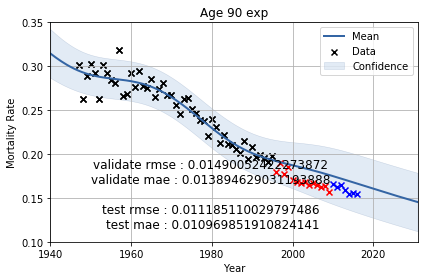

array([ 1.31871584e+07, -9.02192260e-03])

In [12]:
gp_regression(x_train, y_train, exp, (1, -0.00001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[0.03317154]


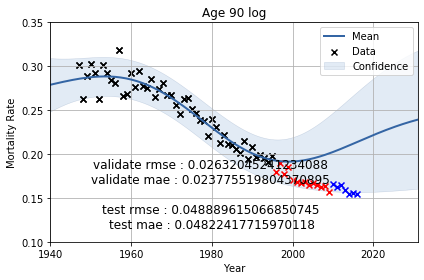

array([0.03317154])

In [13]:
gp_regression(x_train, y_train, log, (0.0001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[ 2.03332468e-06 -1.20630359e-02  2.38519882e+01 -1.57182438e+04]


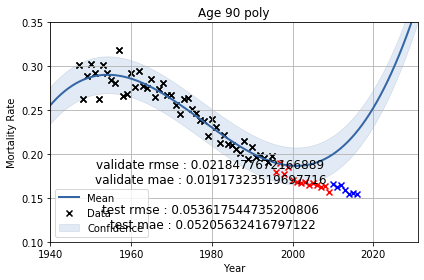

array([ 2.03332468e-06, -1.20630359e-02,  2.38519882e+01, -1.57182438e+04])

In [14]:
gp_regression(x_train, y_train, poly, (0.1, 0.1, 0.1, 0.001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[-2.33827617e-03  4.86042211e+00]


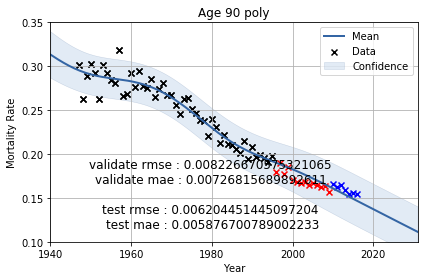

array([-2.33827617e-03,  4.86042211e+00])

In [15]:
gp_regression(x_train, y_train, poly, (0.001, 0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
params:[-9.23416818e-02  1.81848255e+02]


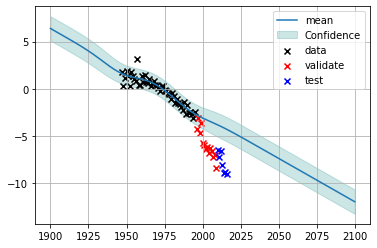

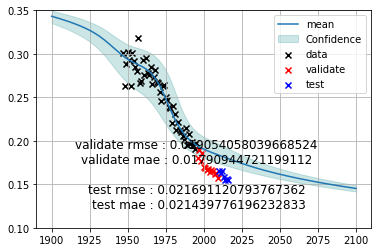

  0%|          | 1/1296 [00:01<25:21,  1.17s/it]

validate rmse : 0.019054058039668524 
 validate mae : 0.01790944721199112 

    test rmse : 0.021691120793767362 
 test mae : 0.021439776196232833
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))
params:[-9.23416756e-02  1.81848242e+02]


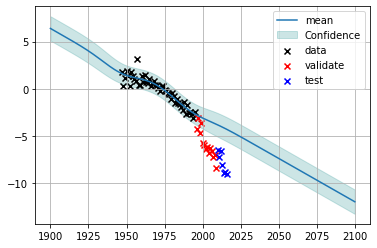

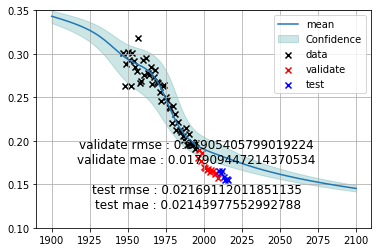

  0%|          | 2/1296 [00:02<28:25,  1.32s/it]

validate rmse : 0.01905405799019224 
 validate mae : 0.017909447214370534 

    test rmse : 0.02169112011851135 
 test mae : 0.02143977552992788
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))
params:[-1.18227091e-01  2.33001695e+02]


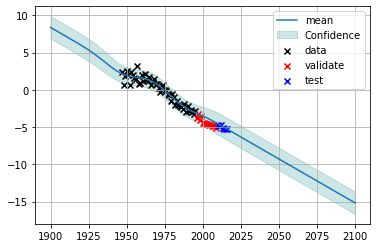

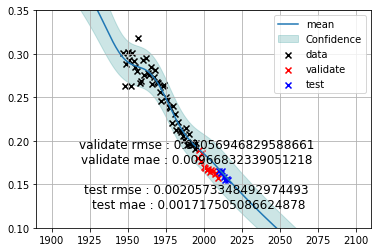

  0%|          | 3/1296 [00:04<32:41,  1.52s/it]

validate rmse : 0.01056946829588661 
 validate mae : 0.00966832339051218 

    test rmse : 0.0020573348492974493 
 test mae : 0.001717505086624878
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))
params:[  -438.65022664 -67323.97966525]


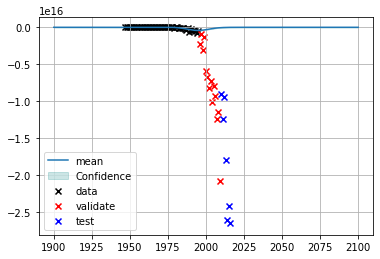

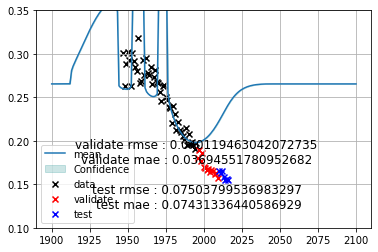

  0%|          | 4/1296 [00:38<5:05:54, 14.21s/it]

validate rmse : 0.040119463042072735 
 validate mae : 0.03694551780952682 

    test rmse : 0.07503799536983297 
 test mae : 0.07431336440586929
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
params:[-9.51593101e-02  1.86341399e+02]


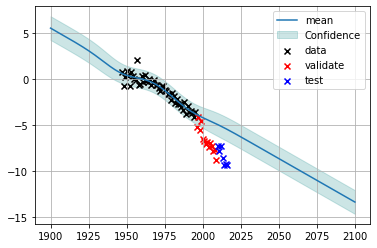

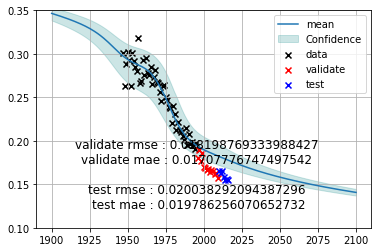

  0%|          | 5/1296 [00:38<3:21:25,  9.36s/it]

validate rmse : 0.018198769333988427 
 validate mae : 0.01707776747497542 

    test rmse : 0.020038292094387296 
 test mae : 0.019786256070652732
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))
params:[-9.15345997e-02  1.78094134e+02]


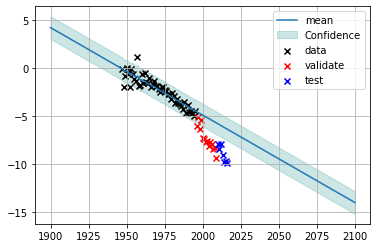

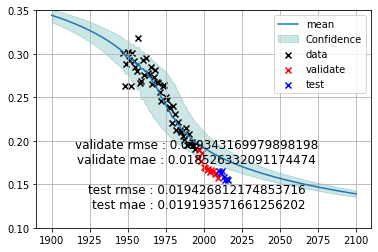

  0%|          | 6/1296 [00:39<2:18:32,  6.44s/it]

validate rmse : 0.019343169979898198 
 validate mae : 0.018526332091174474 

    test rmse : 0.019426812174853716 
 test mae : 0.019193571661256202
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))
params:[-9.23417001e-02  1.81848290e+02]


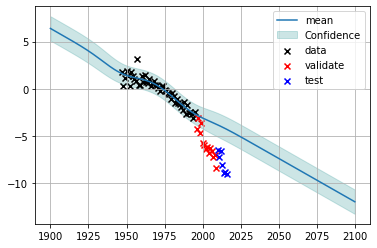

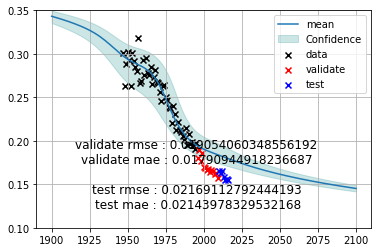

  1%|          | 7/1296 [00:40<1:39:21,  4.63s/it]

validate rmse : 0.019054060348556192 
 validate mae : 0.01790944918236687 

    test rmse : 0.02169112792444193 
 test mae : 0.02143978329532168
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))
params:[-9.23416989e-02  1.81848288e+02]


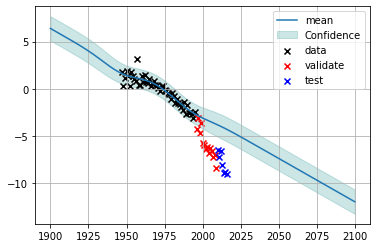

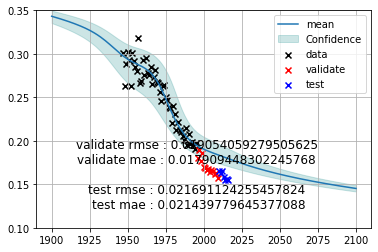

  1%|          | 8/1296 [00:41<1:14:36,  3.48s/it]

validate rmse : 0.019054059279505625 
 validate mae : 0.017909448302245768 

    test rmse : 0.021691124255457824 
 test mae : 0.021439779645377088
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))
params:[-1.18718899e-01  2.33989172e+02]


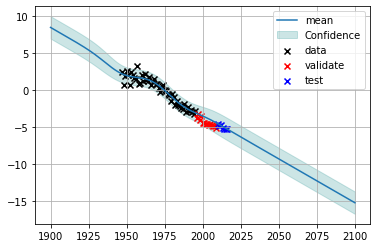

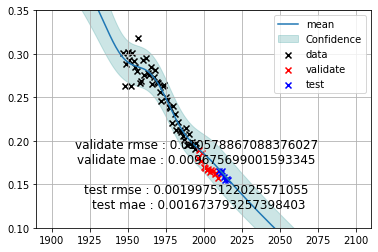

  1%|          | 9/1296 [00:43<1:03:15,  2.95s/it]

validate rmse : 0.010578867088376027 
 validate mae : 0.009675699001593345 

    test rmse : 0.0019975122025571055 
 test mae : 0.001673793257398403
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1.48039527e+05  2.90417867e+08]


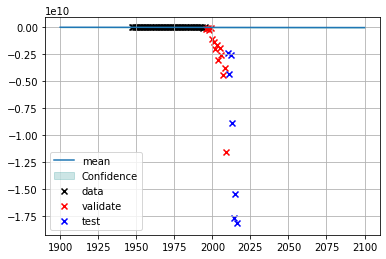

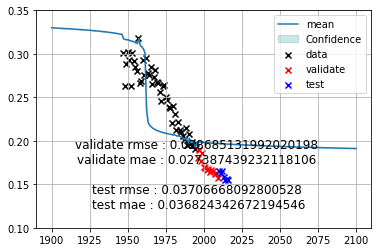

  1%|          | 10/1296 [00:45<1:00:14,  2.81s/it]

validate rmse : 0.028685131992020198 
 validate mae : 0.027387439232118106 

    test rmse : 0.03706668092800528 
 test mae : 0.036824342672194546
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))
params:[ 3.72813663e-02 -7.18756250e+01]


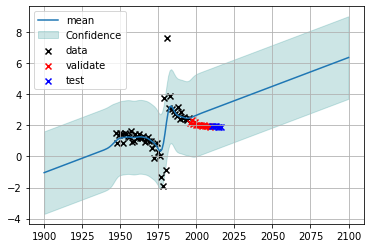

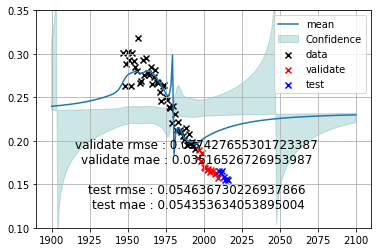

  1%|          | 11/1296 [00:46<46:39,  2.18s/it]  

validate rmse : 0.037427655301723387 
 validate mae : 0.03516526726953987 

    test rmse : 0.054636730226937866 
 test mae : 0.054353634053895004
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))
params:[-9.15347296e-02  1.78094388e+02]


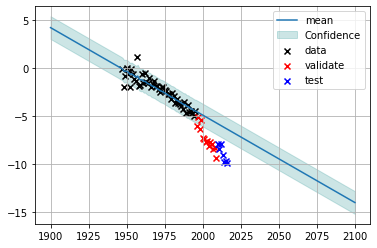

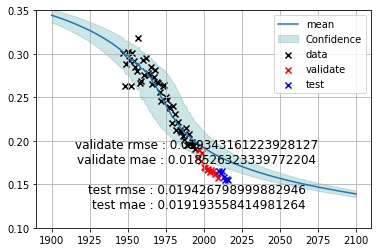

  1%|          | 12/1296 [00:47<37:53,  1.77s/it]

validate rmse : 0.019343161223928127 
 validate mae : 0.018526323339772204 

    test rmse : 0.019426798999882946 
 test mae : 0.019193558414981264
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))
params:[-1.18501296e-01  2.33621874e+02]


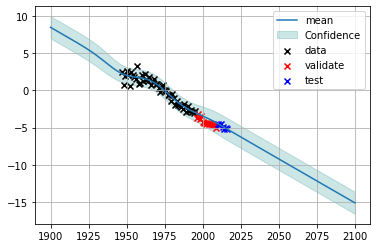

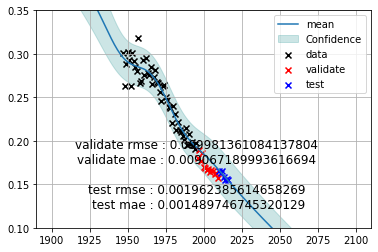

  1%|          | 13/1296 [00:49<37:31,  1.75s/it]

validate rmse : 0.009981361084137804 
 validate mae : 0.009067189993616694 

    test rmse : 0.001962385614658269 
 test mae : 0.001489746745320129
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 2))
params:[-1.18482087e-01  2.33582171e+02]


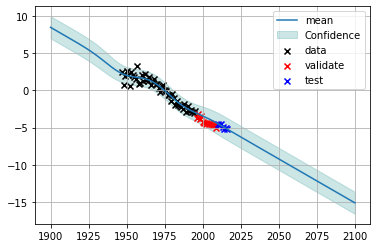

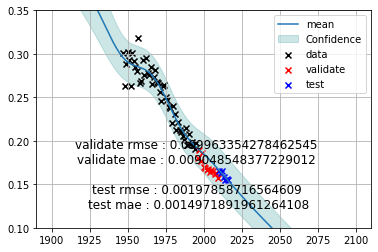

  1%|          | 14/1296 [00:50<37:17,  1.75s/it]

validate rmse : 0.009963354278462545 
 validate mae : 0.009048548377229012 

    test rmse : 0.00197858716564609 
 test mae : 0.0014971891961264108
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 1))
params:[-1.15571816e-01  2.27590859e+02]


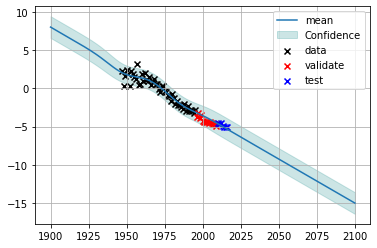

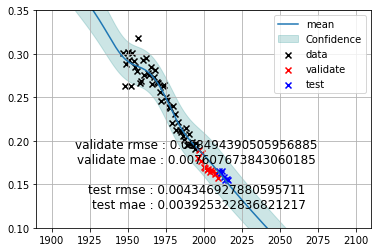

  1%|          | 15/1296 [00:52<39:14,  1.84s/it]

validate rmse : 0.008494390505956885 
 validate mae : 0.007607673843060185 

    test rmse : 0.004346927880595711 
 test mae : 0.003925322836821217
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 2))
params:[-1.15563555e-01  2.27612070e+02]


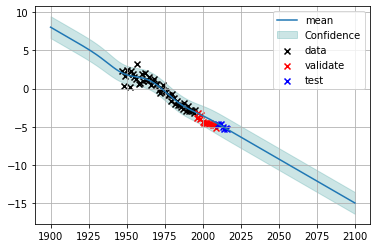

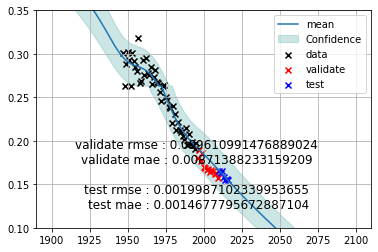

  1%|          | 16/1296 [01:04<1:40:36,  4.72s/it]

validate rmse : 0.009610991476889024 
 validate mae : 0.00871388233159209 

    test rmse : 0.0019987102339953655 
 test mae : 0.0014677795672887104
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 1))
params:[-1.16427702e-01  2.28555624e+02]


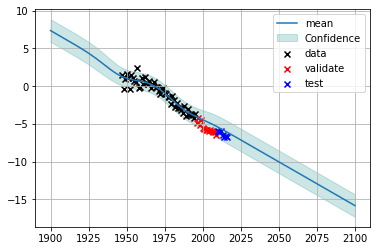

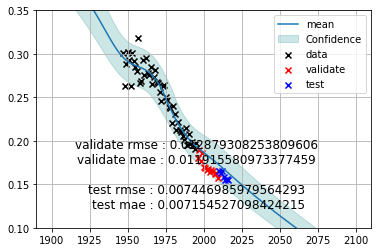

  1%|▏         | 17/1296 [01:06<1:25:36,  4.02s/it]

validate rmse : 0.012879308253809606 
 validate mae : 0.011915580973377459 

    test rmse : 0.007446985979564293 
 test mae : 0.007154527098424215
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 2))
params:[-1.16616763e-01  2.27868350e+02]


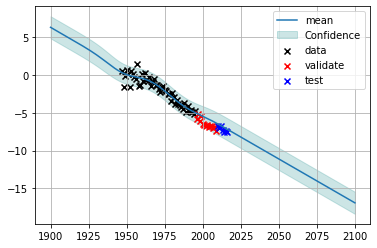

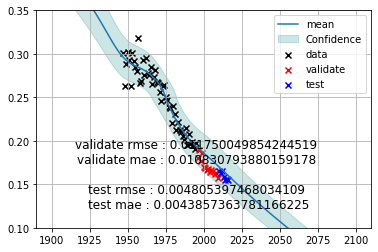

  1%|▏         | 18/1296 [01:08<1:11:46,  3.37s/it]

validate rmse : 0.011750049854244519 
 validate mae : 0.010830793880159178 

    test rmse : 0.004805397468034109 
 test mae : 0.0043857363781166225
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 1))
params:[-1.21785218e-01  2.39546272e+02]


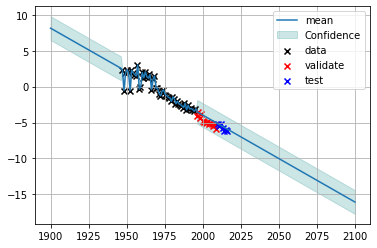

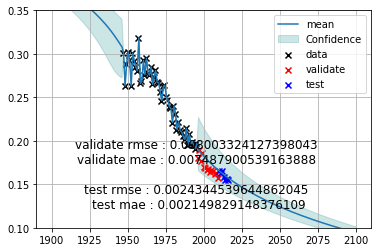

  1%|▏         | 19/1296 [01:18<1:54:10,  5.36s/it]

validate rmse : 0.008003324127398043 
 validate mae : 0.007487900539163888 

    test rmse : 0.0024344539644862045 
 test mae : 0.002149829148376109
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 2))
params:[-1.21956271e-01  2.38543621e+02]


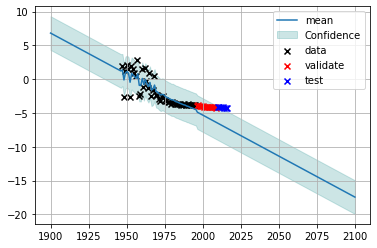

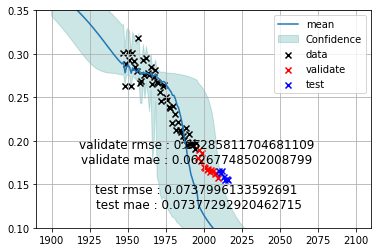

  2%|▏         | 20/1296 [01:28<2:21:37,  6.66s/it]

validate rmse : 0.06285811704681109 
 validate mae : 0.06267748502008799 

    test rmse : 0.0737996133592691 
 test mae : 0.07377292920462715
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 1))
params:[-1.02634032e-01  2.01982897e+02]


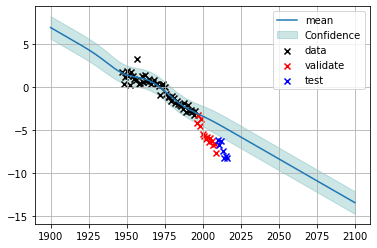

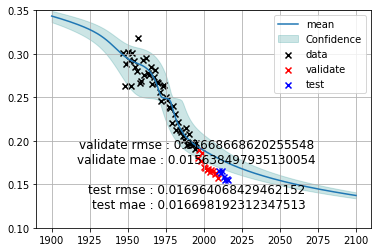

  2%|▏         | 21/1296 [01:31<2:03:11,  5.80s/it]

validate rmse : 0.01668668620255548 
 validate mae : 0.015638497935130054 

    test rmse : 0.016964068429462152 
 test mae : 0.016698192312347513
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 2))
params:[-1.1590099e-01  2.2851037e+02]


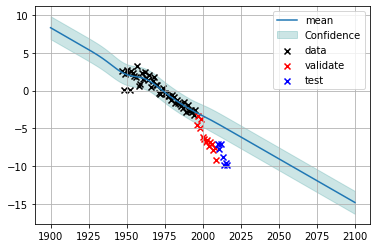

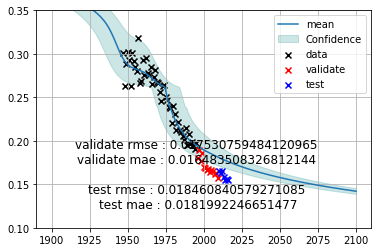

  2%|▏         | 22/1296 [01:46<2:57:50,  8.38s/it]

validate rmse : 0.017530759484120965 
 validate mae : 0.016483508326812144 

    test rmse : 0.018460840579271085 
 test mae : 0.0181992246651477
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 1))
params:[-1.55469905e-02  3.59984818e+01]


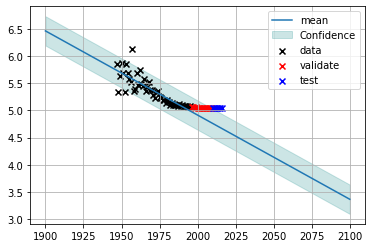

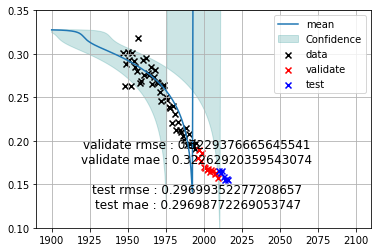

  2%|▏         | 23/1296 [01:48<2:19:34,  6.58s/it]

validate rmse : 0.3229376665645541 
 validate mae : 0.32262920359543074 

    test rmse : 0.29699352277208657 
 test mae : 0.29698772269053747
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 2))
params:[-2.14398744e-02  2.65425041e+01]


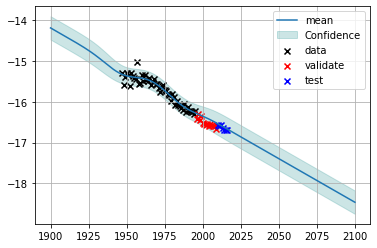

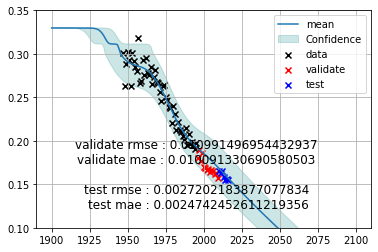

  2%|▏         | 24/1296 [01:55<2:22:15,  6.71s/it]

validate rmse : 0.010991496954432937 
 validate mae : 0.010091330690580503 

    test rmse : 0.0027202183877077834 
 test mae : 0.0024742452611219356
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
params:[-8.77006362e-02  1.71973660e+02]


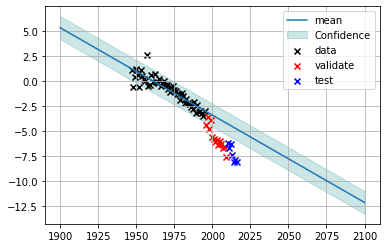

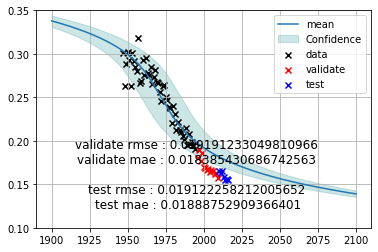

  2%|▏         | 25/1296 [01:56<1:44:21,  4.93s/it]

validate rmse : 0.019191233049810966 
 validate mae : 0.018385430686742563 

    test rmse : 0.019122258212005652 
 test mae : 0.01888752909366401
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 2))
params:[-8.77005829e-02  1.71973555e+02]


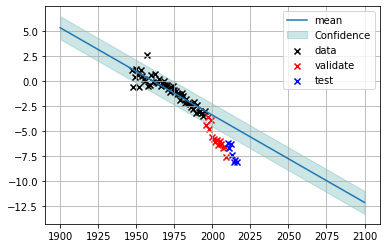

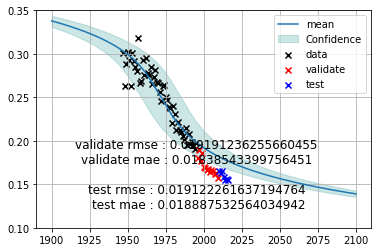

  2%|▏         | 26/1296 [01:57<1:17:58,  3.68s/it]

validate rmse : 0.019191236255660455 
 validate mae : 0.01838543399756451 

    test rmse : 0.019122261637194764 
 test mae : 0.018887532564034942
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 1))
params:[-1.17294144e-01  2.31207905e+02]


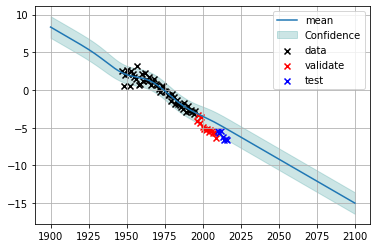

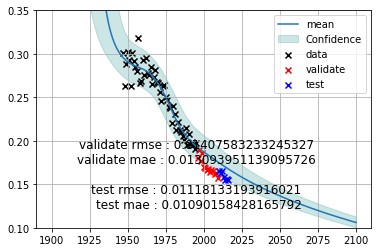

  2%|▏         | 27/1296 [02:00<1:13:03,  3.45s/it]

validate rmse : 0.01407583233245327 
 validate mae : 0.013093951139095726 

    test rmse : 0.01118133193916021 
 test mae : 0.01090158428165792
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 2))
params:[-5.16680928e+06  1.01308094e+10]


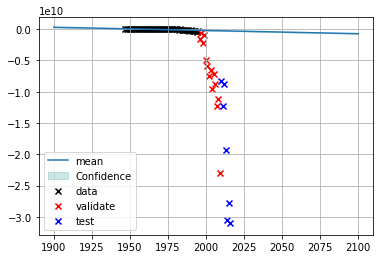

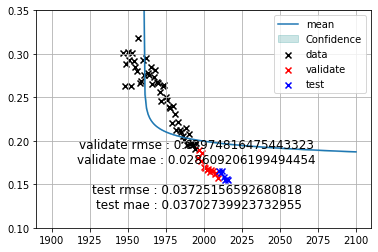

  2%|▏         | 28/1296 [02:02<1:02:34,  2.96s/it]

validate rmse : 0.02974816475443323 
 validate mae : 0.028609206199494454 

    test rmse : 0.03725156592680818 
 test mae : 0.03702739923732955
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
params:[-9.49113389e-02  1.84680068e+02]


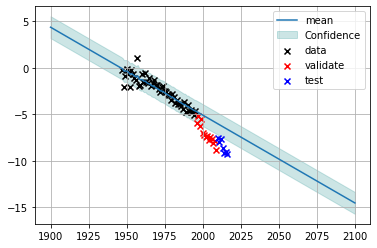

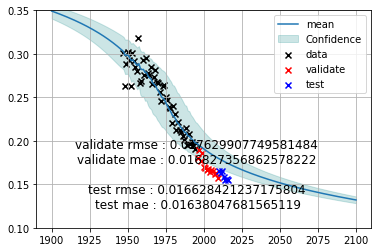

  2%|▏         | 29/1296 [02:02<48:01,  2.27s/it]  

validate rmse : 0.017629907749581484 
 validate mae : 0.016827356862578222 

    test rmse : 0.016628421237175804 
 test mae : 0.01638047681565119
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 2))
params:[-8.88970878e-02  1.71776618e+02]


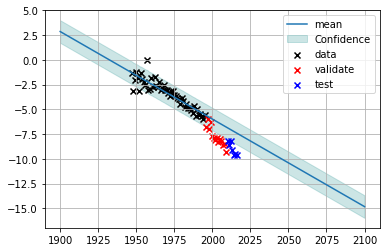

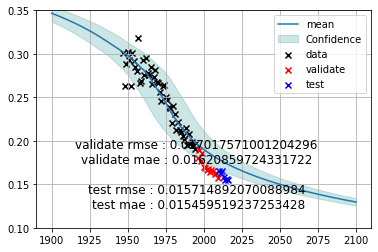

  2%|▏         | 30/1296 [02:03<38:02,  1.80s/it]

validate rmse : 0.017017571001204296 
 validate mae : 0.01620859724331722 

    test rmse : 0.015714892070088984 
 test mae : 0.015459519237253428
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 1))
params:[-7.75548523e-02  1.51300520e+02]


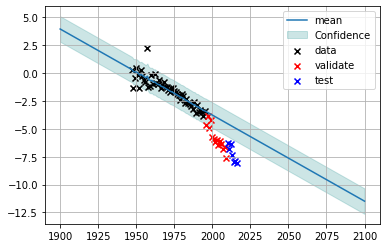

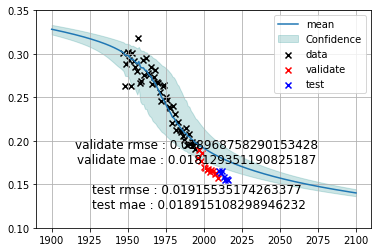

  2%|▏         | 31/1296 [02:04<31:14,  1.48s/it]

validate rmse : 0.018968758290153428 
 validate mae : 0.018129351190825187 

    test rmse : 0.01915535174263377 
 test mae : 0.018915108298946232
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 2))
params:[-7.75550668e-02  1.51300945e+02]


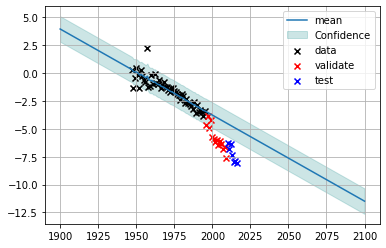

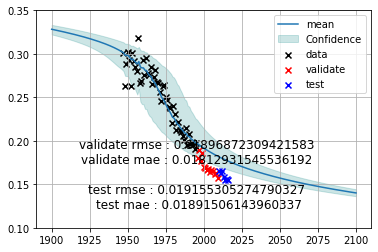

  2%|▏         | 32/1296 [02:05<27:24,  1.30s/it]

validate rmse : 0.01896872309421583 
 validate mae : 0.01812931545536192 

    test rmse : 0.019155305274790327 
 test mae : 0.01891506143960337
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 1))
params:[-1.09346233e-01  2.15650110e+02]


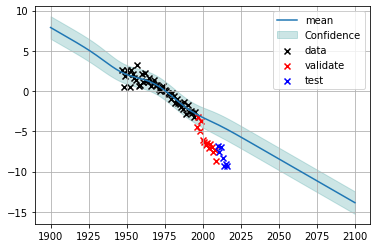

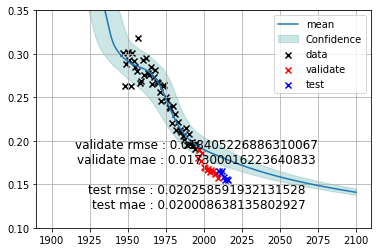

  3%|▎         | 33/1296 [02:05<25:16,  1.20s/it]

validate rmse : 0.018405226886310067 
 validate mae : 0.017300016223640833 

    test rmse : 0.020258591932131528 
 test mae : 0.020008638135802927
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 2))
params:[-1.18141876e-01  2.32869961e+02]


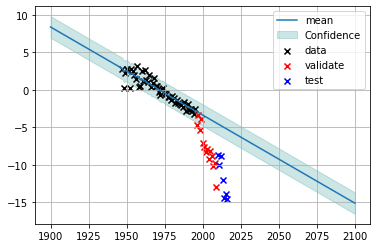

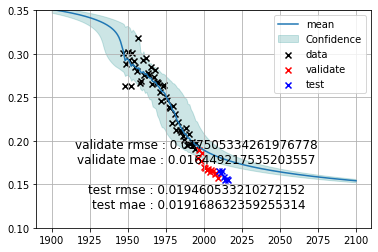

  3%|▎         | 34/1296 [02:10<44:18,  2.11s/it]

validate rmse : 0.017505334261976778 
 validate mae : 0.016449217535203557 

    test rmse : 0.019460533210272152 
 test mae : 0.019168632359255314
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 1))
params:[-8.63743131e-02  1.66838153e+02]


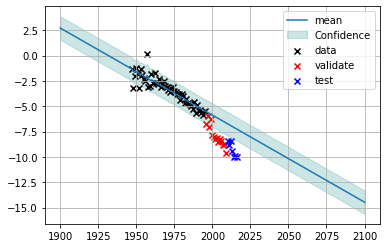

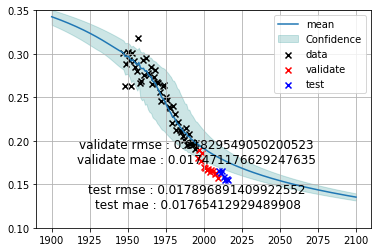

  3%|▎         | 35/1296 [02:10<36:01,  1.71s/it]

validate rmse : 0.01829549050200523 
 validate mae : 0.017471176629247635 

    test rmse : 0.017896891409922552 
 test mae : 0.01765412929489908
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 2))
params:[-7.47075088e-02  1.42812155e+02]


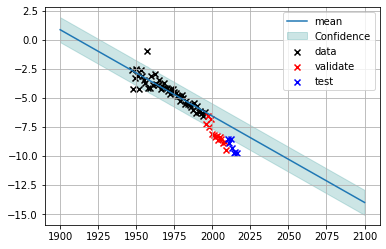

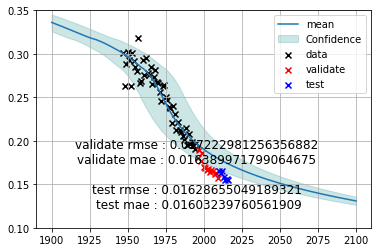

  3%|▎         | 36/1296 [02:11<30:21,  1.45s/it]

validate rmse : 0.017222981256356882 
 validate mae : 0.016389971799064675 

    test rmse : 0.01628655049189321 
 test mae : 0.01603239760561909
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 1))
params:[-9.23416857e-02  1.81848262e+02]


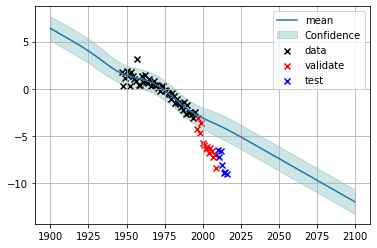

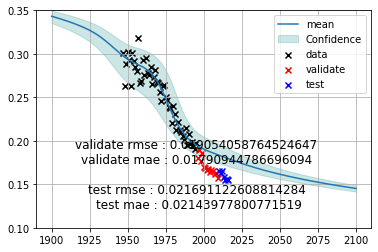

  3%|▎         | 37/1296 [02:12<26:25,  1.26s/it]

validate rmse : 0.019054058764524647 
 validate mae : 0.01790944786696094 

    test rmse : 0.021691122608814284 
 test mae : 0.02143977800771519
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 2))
params:[-9.23416771e-02  1.81848245e+02]


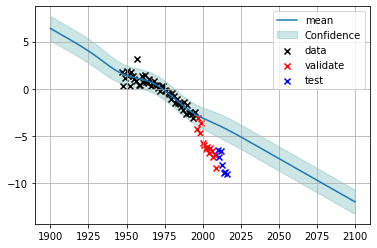

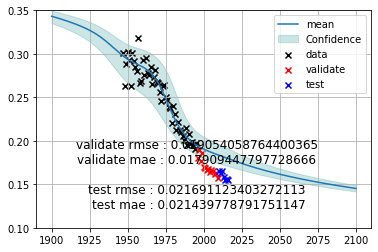

  3%|▎         | 38/1296 [02:13<25:13,  1.20s/it]

validate rmse : 0.019054058764400365 
 validate mae : 0.017909447797728666 

    test rmse : 0.021691123403272113 
 test mae : 0.021439778791751147
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 1))
params:[-1.18712128e-01  2.33974273e+02]


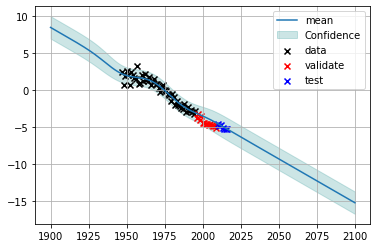

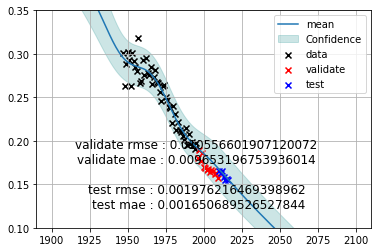

  3%|▎         | 39/1296 [02:15<29:43,  1.42s/it]

validate rmse : 0.010556601907120072 
 validate mae : 0.009653196753936014 

    test rmse : 0.001976216469398962 
 test mae : 0.001650689526527844
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 2))
params:[-6.75713171e-01  1.31591925e+03]


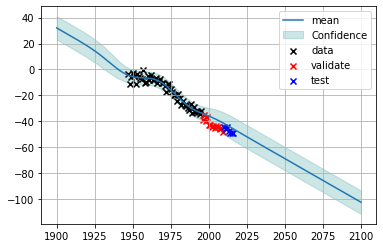

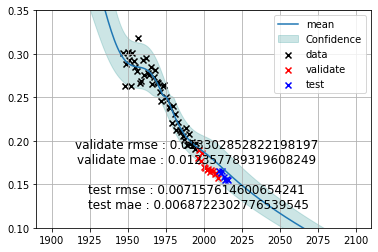

  3%|▎         | 40/1296 [02:21<57:30,  2.75s/it]

validate rmse : 0.013302852822198197 
 validate mae : 0.012357789319608249 

    test rmse : 0.007157614600654241 
 test mae : 0.0068722302776539545
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 1))
params:[-9.51593377e-02  1.86341453e+02]


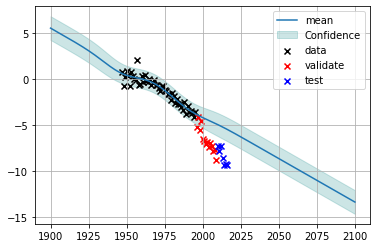

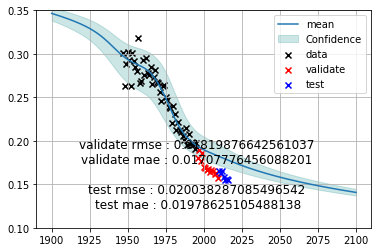

  3%|▎         | 41/1296 [02:22<44:58,  2.15s/it]

validate rmse : 0.01819876642561037 
 validate mae : 0.01707776456088201 

    test rmse : 0.020038287085496542 
 test mae : 0.01978625105488138
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 2))
params:[-9.15345773e-02  1.78094090e+02]


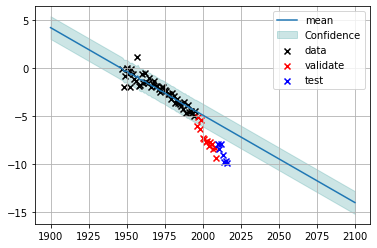

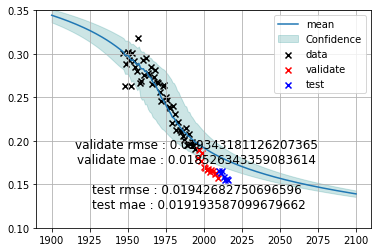

  3%|▎         | 42/1296 [02:23<36:35,  1.75s/it]

validate rmse : 0.019343181126207365 
 validate mae : 0.018526343359083614 

    test rmse : 0.01942682750696596 
 test mae : 0.019193587099679662
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 1))
params:[-9.23416873e-02  1.81848265e+02]


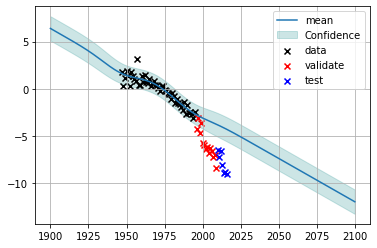

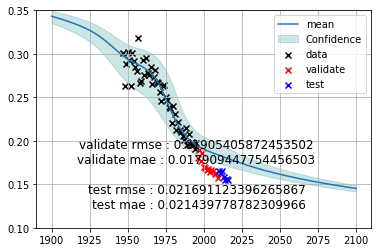

  3%|▎         | 43/1296 [02:23<31:23,  1.50s/it]

validate rmse : 0.01905405872453502 
 validate mae : 0.017909447754456503 

    test rmse : 0.021691123396265867 
 test mae : 0.021439778782309966
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 2))
params:[-9.23417002e-02  1.81848291e+02]


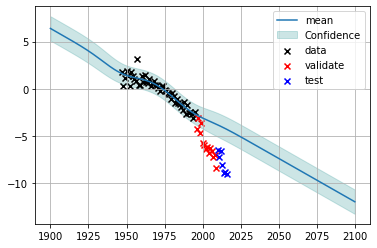

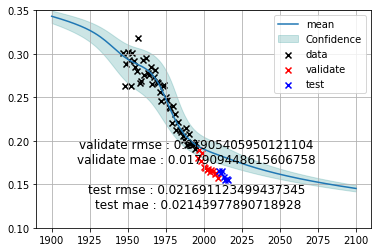

  3%|▎         | 44/1296 [02:25<28:32,  1.37s/it]

validate rmse : 0.01905405950121104 
 validate mae : 0.017909448615606758 

    test rmse : 0.021691123499437345 
 test mae : 0.02143977890718928
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 1))
params:[-1.18685150e-01  2.33919117e+02]


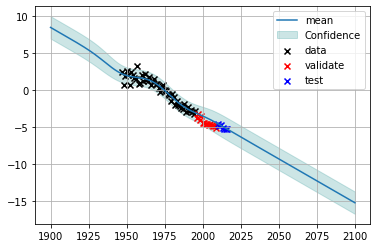

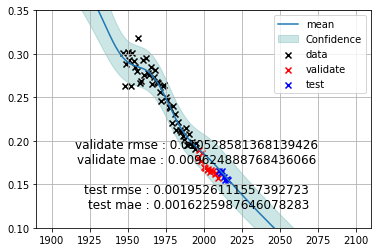

  3%|▎         | 45/1296 [02:28<40:40,  1.95s/it]

validate rmse : 0.010528581368139426 
 validate mae : 0.009624888768436066 

    test rmse : 0.0019526111557392723 
 test mae : 0.0016225987646078283
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 2))
params:[-649.43726234 -369.72497999]


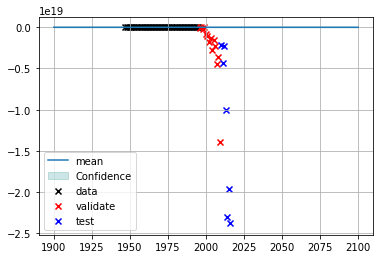

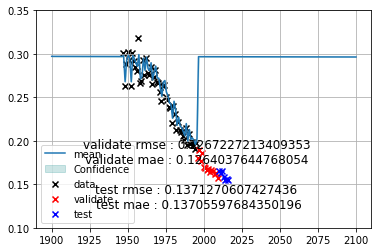

  4%|▎         | 46/1296 [02:49<2:41:40,  7.76s/it]

validate rmse : 0.1267227213409353 
 validate mae : 0.1264037644768054 

    test rmse : 0.1371270607427436 
 test mae : 0.13705597684350196
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 1))
params:[-9.51592922e-02  1.86341364e+02]


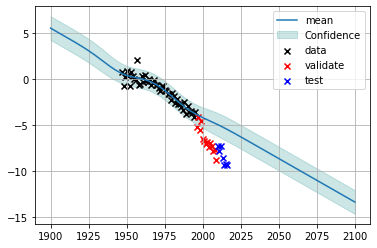

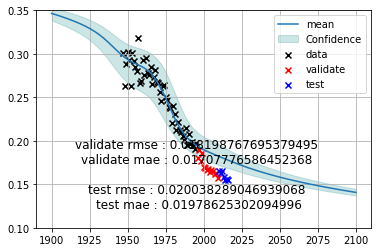

  4%|▎         | 47/1296 [02:50<1:58:29,  5.69s/it]

validate rmse : 0.018198767695379495 
 validate mae : 0.01707776586452368 

    test rmse : 0.020038289046939068 
 test mae : 0.01978625302094996
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 2))
params:[-9.15345430e-02  1.78094027e+02]


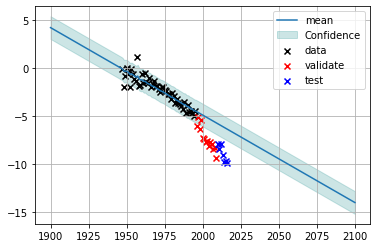

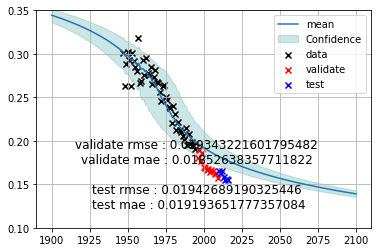

  4%|▎         | 48/1296 [02:51<1:29:19,  4.29s/it]

validate rmse : 0.019343221601795482 
 validate mae : 0.01852638357711822 

    test rmse : 0.01942689190325446 
 test mae : 0.019193651777357084
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 1))
params:[-1.18480774e-01  2.33579724e+02]


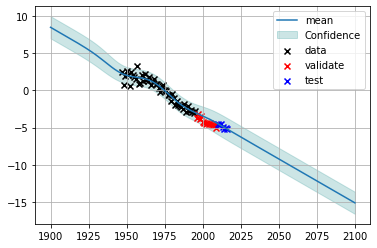

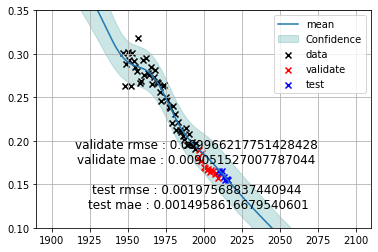

  4%|▍         | 49/1296 [02:53<1:16:47,  3.70s/it]

validate rmse : 0.009966217751428428 
 validate mae : 0.009051527007787044 

    test rmse : 0.00197568837440944 
 test mae : 0.0014958616679540601
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 2))
params:[-1.18505805e-01  2.33631351e+02]


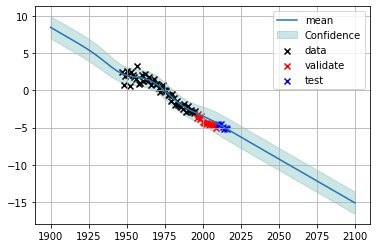

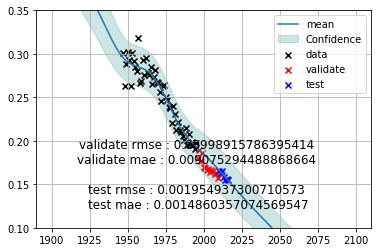

  4%|▍         | 50/1296 [02:56<1:08:14,  3.29s/it]

validate rmse : 0.00998915786395414 
 validate mae : 0.009075294488868664 

    test rmse : 0.001954937300710573 
 test mae : 0.0014860357074569547
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 1))
params:[-1.15015492e-01  2.26493467e+02]


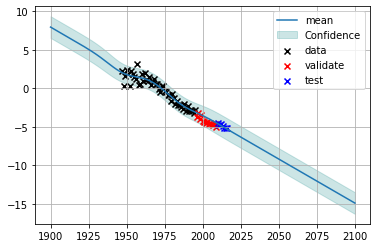

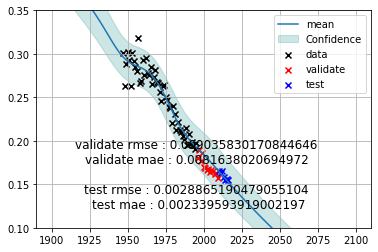

  4%|▍         | 51/1296 [02:58<1:00:47,  2.93s/it]

validate rmse : 0.009035830170844646 
 validate mae : 0.0081638020694972 

    test rmse : 0.0028865190479055104 
 test mae : 0.002339593919002197
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2))


In [ ]:
result = grid_search(cwgp_regression, x_train, y_train, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]},
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test,
                     func=poly, init_params=(1,-0.1)
                    )